Install appropriate packages and load in datasets from NHANES

In [127]:
# !pip install xport pandas numpy matplotlib scikit-learn pyreadstat

In [128]:
from xport import XportReader
import os
from pyreadstat import read_xport
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# DPQ_L.xpt is the dataset containg depression questions
with open("datasets/questionaire_data/DPQ_L.xpt", "rb") as f:
    reader = XportReader(f)
    df = pd.DataFrame(reader)

Describe the dataset

In [129]:
display(df)

,SEQN,DPQ010,DPQ020,DPQ030,DPQ040,DPQ050,DPQ060,DPQ070,DPQ080,DPQ090,DPQ100
0,130378.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,130379.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,130380.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,130386.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,130387.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
6332,142305.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6333,142307.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
6334,142308.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
6335,142309.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


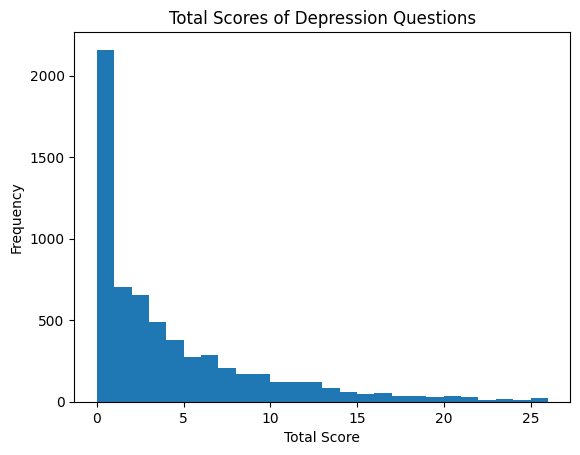

In [130]:
# counts of total sums across all questions of last 10 columns only add if value is 1, 2, 3
df["DPQSUM"] = df.iloc[:, -10:].apply(lambda x: x[x.isin([1, 2, 3])].sum(), axis=1)

# histogram of the sums
plt.hist(df["DPQSUM"], bins=range(0, 27, 1))
plt.title("Total Scores of Depression Questions")
plt.xlabel("Total Score")
plt.ylabel("Frequency")
plt.show()

Load in the other data sets for prediction and casual understanding of depression scores

In [131]:
base_dir = "datasets"
dataframes = {}

for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file.endswith(".xpt"):
            file_path = os.path.join(root, file)
            dataset_name = os.path.splitext(file)[0]
            new_df = pd.read_sas(file_path, format='xport', encoding='latin1')
            dataframes[dataset_name] = new_df
            print(f"Loaded dataset: {dataset_name}")


Loaded dataset: DEMO_L
Loaded dataset: DR1TOT_L
Loaded dataset: DR2TOT_L


c:\Users\Simon\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\sas\sas_xport.py:475: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[x] = v


Loaded dataset: BMX_L
Loaded dataset: FERTIN_L
Loaded dataset: FOLATE_L
Loaded dataset: GHB_L
Loaded dataset: HSCRP_L
Loaded dataset: PBCD_L
Loaded dataset: TCHOL_L
Loaded dataset: TFR_L
Loaded dataset: VID_L
Loaded dataset: ALQ_L
Loaded dataset: BAQ_L
Loaded dataset: BPQ_L
Loaded dataset: DIQ_L
Loaded dataset: DPQ_L
Loaded dataset: HIQ_L
Loaded dataset: HOQ_L
Loaded dataset: HUQ_L
Loaded dataset: IMQ_L
Loaded dataset: INQ_L
Loaded dataset: KIQ_U_L
Loaded dataset: MCQ_L
Loaded dataset: OCQ_L
Loaded dataset: OHQ_L
Loaded dataset: PAQ_L
Loaded dataset: RXQ_RX_L
Loaded dataset: SLQ_L
Loaded dataset: SMQFAM_L
Loaded dataset: SMQRTU_L
Loaded dataset: SMQ_L
Loaded dataset: WHQ_L


Overlapping SEQNs among all datasets

In [132]:
dataframes = list(dataframes.values())
# add depression df
dataframes.append(df)

common_seqn = set(dataframes[0]["SEQN"])
for df in dataframes[1:]:
    common_seqn = common_seqn.intersection(df["SEQN"])

print("Number of SEQNs in all dataframes:", len(common_seqn))

Number of SEQNs in all dataframes: 1332


In [133]:
merged_df = reduce(lambda left, right: pd.merge(left, right, on='SEQN', how='inner'), dataframes)

display(merged_df)

C:\Users\Simon\AppData\Local\Temp\ipykernel_39300\2438708765.py:1: FutureWarning: Passing 'suffixes' which cause duplicate columns {'WTPH2YR_x'} in the result is deprecated and will raise a MergeError in a future version.
  merged_df = reduce(lambda left, right: pd.merge(left, right, on='SEQN', how='inner'), dataframes)


,SEQN,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,...,DPQ020_y,DPQ030_y,DPQ040_y,DPQ050_y,DPQ060_y,DPQ070_y,DPQ080_y,DPQ090_y,DPQ100_y,DPQSUM
0,130380.0,12.0,2.0,2.0,44.0,NaN,2.0,2.0,1.0,NaN,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
1,130388.0,12.0,2.0,2.0,27.0,NaN,4.0,4.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,130390.0,12.0,2.0,2.0,31.0,NaN,3.0,3.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,130391.0,12.0,2.0,2.0,33.0,NaN,3.0,3.0,2.0,NaN,...,3.0,3.0,3.0,3.0,3.0,3.0,2.0,1.0,2.0,26.0
4,130395.0,12.0,2.0,2.0,33.0,NaN,5.0,7.0,2.0,NaN,...,1.0,2.0,3.0,3.0,1.0,2.0,1.0,0.0,0.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1327,142269.0,12.0,2.0,2.0,32.0,NaN,4.0,4.0,2.0,NaN,...,3.0,3.0,2.0,3.0,3.0,1.0,1.0,3.0,1.0,21.0
1328,142280.0,12.0,2.0,2.0,23.0,NaN,5.0,7.0,2.0,NaN,...,2.0,2.0,2.0,2.0,0.0,3.0,0.0,2.0,2.0,18.0
1329,142283.0,12.0,2.0,2.0,29.0,NaN,5.0,7.0,1.0,NaN,...,2.0,3.0,2.0,3.0,0.0,0.0,1.0,0.0,1.0,14.0
1330,142300.0,12.0,2.0,2.0,46.0,NaN,1.0,1.0,1.0,NaN,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0


In [134]:
# Fix physical activity columns to be standardized

unit_conversion = {'D': 365, 'W': 52.14, 'M': 12, 'Y': 1}

def standardize_frequency(row, freq_col, unit_col):
    if pd.isna(row[unit_col]) or pd.isna(row[freq_col]):
        return None  
    return row[freq_col] * unit_conversion.get(row[unit_col], 1)

merged_df['PAD790_annualized'] = merged_df.apply(
    lambda row: standardize_frequency(row, 'PAD790Q', 'PAD790U'), axis=1)

merged_df['PAD810_annualized'] = merged_df.apply(
    lambda row: standardize_frequency(row, 'PAD810Q', 'PAD810U'), axis=1)

merged_df['PAD790_total_minutes'] = merged_df['PAD790_annualized'] * merged_df['PAD800']
merged_df['PAD810_total_minutes'] = merged_df['PAD810_annualized'] * merged_df['PAD820']

merged_df = merged_df.drop(columns=['PAD800', 'PAD820'])
merged_df = merged_df.drop(columns=['PAD790Q', 'PAD790U', 'PAD810Q', 'PAD810U'])

In [ ]:
# missingness percentage for each column
missingness = merged_df.isnull().sum()
missingness = missingness[missingness > 0]
missingness = missingness.sort_values(ascending=False)
missingness = missingness / len(merged_df) * 100
for i, v in missingness.items():
    print(f"{i}: {v:.2f}%")

# drop columns with more than 20% missing values
merged_df = merged_df.drop(columns=missingness[missingness > 30].index)

merged_df = merged_df.dropna()

RIDAGEMN: 100.00%
DRD370JQ: 100.00%
MCQ149: 100.00%
BMDBMIC: 100.00%
MCQ500: 100.00%
BMIHEAD: 100.00%
BMXHEAD: 100.00%
MCQ230C: 100.00%
MCQ230D: 100.00%
BMIRECUM: 100.00%
BMXRECUM: 100.00%
RIDEXAGM: 100.00%
DRQSDT6: 100.00%
DRQSDT5: 100.00%
IMQ070: 100.00%
DMDHRMAZ: 100.00%
DMDHRGND: 100.00%
SMQ621: 100.00%
DRD370PQ: 100.00%
DMDHSEDZ: 100.00%
DMDHREDZ: 100.00%
SMD630: 100.00%
DMDHRAGZ: 100.00%
SMQ690E: 99.92%
MCQ510E: 99.92%
SMQ740: 99.92%
DRQSDT8: 99.92%
DRQSDT12: 99.92%
HIQ032C: 99.92%
SMQ690B: 99.92%
MCQ230B: 99.85%
MCQ510B: 99.85%
DRD350JQ: 99.85%
HIQ032E: 99.85%
DRD370LQ: 99.85%
MCQ510C: 99.77%
SMQ690K: 99.77%
DRD370IQ: 99.70%
DRD370SQ: 99.70%
SMQ690D: 99.70%
BMIHT: 99.62%
DRD370CQ: 99.62%
DRD370QQ: 99.55%
DRQSDT2: 99.47%
DRD370OQ: 99.40%
DRQSDT3: 99.40%
SMQ690F: 99.40%
DRQSDT11: 99.40%
MCQ510D: 99.40%
DRQSDT10: 99.25%
MCQ510F: 99.25%
DRQSDT7: 99.10%
DRQSDT4: 99.10%
DRD350CQ: 99.02%
SMQ845: 98.95%
SMQ690G: 98.95%
DRD370FQ: 98.95%
DRD370HQ: 98.87%
DIQ060U: 98.65%
DRD370GQ: 98.65%
D

In [136]:
# need just one column for depression score not individual questions, but keep dpq sum column
merged_df = merged_df.drop(columns=merged_df.columns[merged_df.columns.str.startswith("DPQ") & ~merged_df.columns.str.startswith("DPQSUM")])

# dpqsum at end
merged_df = merged_df[[c for c in merged_df if c != 'DPQSUM'] + ['DPQSUM']]

In [137]:
# split up target (dpqsum) two different ways: binary (depressed or not) and continuous (minimal, mild, moderate, moderately severe, severe)
# Binary: 0-9 not depressed, 10-27 depressed
# Continuous: 0-4 minimal, 5-9 mild, 10-14 moderate, 15-19 moderately severe, 20-27 severe

# add binary target
merged_df["DEPRESSED"] = merged_df["DPQSUM"].apply(lambda x: 1 if x >= 10 else 0)
# add continuous target 1-5
merged_df["DEPRESSION_LEVEL"] = merged_df["DPQSUM"].apply(lambda x: 1 if x < 5 else 2 if x < 10 else 3 if x < 15 else 4 if x < 20 else 5)

# distribution of these targets
print("Binary Target Distribution:")
print(merged_df["DEPRESSED"].value_counts())
print("Continuous Target Distribution:")
print(merged_df["DEPRESSION_LEVEL"].value_counts())



Binary Target Distribution:
0    998
1    216
Name: DEPRESSED, dtype: int64
Continuous Target Distribution:
1    723
2    275
3    142
4     46
5     28
Name: DEPRESSION_LEVEL, dtype: int64


In [138]:
not_depressed = merged_df[merged_df['DEPRESSED'] == 0]
depressed = merged_df[merged_df['DEPRESSED'] == 1]

# randomly remove some not depressed samples to balance the dataset
not_depressed_downsampled = resample(not_depressed, 
                                     replace=False,
                                     n_samples=len(depressed),
                                     random_state=42)

balanced_df = pd.concat([not_depressed_downsampled, depressed])
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

print("New Binary Target Distribution:")
print(balanced_df['DEPRESSED'].value_counts())

New Binary Target Distribution:
1    216
0    216
Name: DEPRESSED, dtype: int64


In [139]:
# remove dpqsum column
balanced_df = balanced_df.drop(columns="DPQSUM")

In [140]:
display(balanced_df)

,SEQN,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDRETH1,RIDRETH3,RIDEXMON,DMQMILIZ,DMDBORN4,...,SMQ020,SMAQUEX2,WHD010,WHD020,WHD050,WHQ070,PAD790_annualized,PAD810_annualized,DEPRESSED,DEPRESSION_LEVEL
0,141863.0,12.0,2.0,2.0,25.0,1.0,1.0,2.0,2.0,1.0,...,2.0,1.0,66.0,250.0,250.0,2.0,7.300000e+02,5.397605e-79,1,4
1,141166.0,12.0,2.0,2.0,39.0,3.0,3.0,1.0,2.0,1.0,...,1.0,1.0,64.0,160.0,150.0,1.0,5.397605e-79,5.397605e-79,0,2
2,132914.0,12.0,2.0,2.0,43.0,1.0,1.0,1.0,2.0,2.0,...,2.0,1.0,62.0,198.0,198.0,1.0,5.397605e-79,5.397605e-79,0,1
3,137686.0,12.0,2.0,2.0,38.0,3.0,3.0,2.0,2.0,1.0,...,1.0,1.0,65.0,204.0,215.0,1.0,2.085600e+02,5.397605e-79,0,1
4,139922.0,12.0,2.0,2.0,30.0,3.0,3.0,2.0,2.0,1.0,...,2.0,1.0,68.0,125.0,130.0,2.0,5.214000e+01,1.200000e+01,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,131697.0,12.0,2.0,2.0,34.0,4.0,4.0,1.0,2.0,2.0,...,2.0,1.0,65.0,121.0,119.0,2.0,4.800000e+01,4.800000e+01,0,1
428,140495.0,12.0,2.0,2.0,45.0,3.0,3.0,2.0,2.0,1.0,...,1.0,1.0,64.0,185.0,185.0,2.0,5.214000e+01,5.397605e-79,0,1
429,133835.0,12.0,2.0,2.0,21.0,1.0,1.0,1.0,2.0,1.0,...,2.0,1.0,64.0,247.0,267.0,1.0,1.042800e+02,5.397605e-79,1,3
430,137996.0,12.0,2.0,2.0,40.0,3.0,3.0,2.0,2.0,1.0,...,2.0,1.0,66.0,165.0,162.0,1.0,2.085600e+02,5.397605e-79,1,3


In [141]:
X = balanced_df.drop(columns=["DEPRESSED", "DEPRESSION_LEVEL"])
y_binary = balanced_df["DEPRESSED"]
y_continuous = balanced_df["DEPRESSION_LEVEL"]
X_train, X_test, y_binary_train, y_binary_test, y_continuous_train, y_continuous_test = train_test_split(X, y_binary, y_continuous, test_size=0.2, random_state=42)

In [142]:
# Fix non-numeric SLQ columns

def time_to_minutes(time_str):
    try:
        if pd.isna(time_str) or not isinstance(time_str, str) or ":" not in time_str:
            return None  # Skip invalid values
        h, m = map(int, time_str.split(":"))
        return h * 60 + m
    except Exception as e:
        print(f"Error with value: {time_str} - {e}")
        return None

time_columns = ['SLQ300', 'SLQ310', 'SLQ320', 'SLQ330']
for col in time_columns:
    X_train[col] = X_train[col].apply(time_to_minutes)
    X_test[col] = X_test[col].apply(time_to_minutes)

Try Random Forest model

In [143]:
randomForest = RandomForestClassifier(random_state=42)
randomForest.fit(X_train, y_binary_train)

y_binary_pred = randomForest.predict(X_test)
print("Binary Target Accuracy:", accuracy_score(y_binary_test, y_binary_pred))
print("Binary Target Classification Report:")
print(classification_report(y_binary_test, y_binary_pred))

Binary Target Accuracy: 0.6896551724137931
Binary Target Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.73      0.73        51
           1       0.62      0.64      0.63        36

    accuracy                           0.69        87
   macro avg       0.68      0.68      0.68        87
weighted avg       0.69      0.69      0.69        87

